In [26]:
import cv2
import numpy as np
from typing import Tuple, List, Optional, Union
from collections import deque

from skimage.morphology import skeletonize
from scipy.interpolate import splprep, splev
import heapq

from matplotlib import pyplot as plt
import scienceplots

plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['font.size'] = 8
plt.rcParams['lines.markersize'] = 2.5

class WireAnalyzer():
    def brightness_mask(self, image: np.ndarray) -> np.ndarray:
        """
        Выделяет нить на изображении и создает бинарную маску
        
        Args:
            image: Входное изображение
            
        Returns:
            Бинарная маска выделенной нити
        """
        if image is None or image.size == 0:
            return None
                
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Улучшение контраста для лучшего выделения тусклых участков
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        
        # Бинаризация с пониженным порогом для захвата тусклых участков
        otsu_threshold, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        lower_threshold = max(0, otsu_threshold - 30)  # Снижаем порог для тусклых участков
        _, binary = cv2.threshold(gray, lower_threshold, 255, cv2.THRESH_BINARY)

        # В случае, если нить белая на темном фоне, инвертируем бинарное изображение
        white_pixels = cv2.countNonZero(binary)
        black_pixels = binary.size - white_pixels
        if white_pixels > black_pixels:
            binary = cv2.bitwise_not(binary)

        # Удаление шумов с помощью морфологических операций
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        binary_clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        
        # Соединение разрывов в нити
        binary_clean = cv2.morphologyEx(binary_clean, cv2.MORPH_CLOSE, kernel)

        # Поиск контуров нити
        contours, _ = cv2.findContours(binary_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Если нет контуров, возвращаем пустую маску
        if not contours:
            return np.zeros_like(gray)

        # Находим наибольший контур по площади
        largest_contour = max(contours, key=cv2.contourArea)

        # Создание маски для нити
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

        return mask

    def analyze(self, image: np.ndarray, wire_mask: np.ndarray, thickness: int = 3) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
        """
        Анализирует изображение и строит график яркости вдоль нити
        
        Args:
            image: Входное изображение
            wire_mask: Бинарная маска нити
            thickness: Толщина линии для измерения яркости
            
        Returns:
            Кортеж из (distances, brightness_values)
        """
        # Преобразуем изображение в оттенки серого, если оно цветное
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        
        # Находим начальные и конечные точки нити
        endpoints = self._find_endpoints(wire_mask)
        if endpoints is None:
            return None, None
        
        # Находим путь по ярким точкам с учетом инерции движения
        path_points = self._find_bright_path(gray, wire_mask, endpoints)
        if path_points is None or len(path_points) < 2:
            return None, None
                
        # Сглаживаем путь
        smoothed_path = self._smooth_path(path_points)
        if smoothed_path is None:
            return None, None
        
        # Измеряем яркость вдоль сглаженного пути
        
        # distances, brightness_values = self._measure_brightness_along_path(gray, smoothed_path, thickness)
        brightness_values = {}
        b,g,r = cv2.split(image)
        distances, brightness_values['r'] = self._measure_brightness_along_path(r, smoothed_path, thickness)
        distances, brightness_values['g'] = self._measure_brightness_along_path(g, smoothed_path, thickness)
        distances, brightness_values['b'] = self._measure_brightness_along_path(b, smoothed_path, thickness)
        
        # Визуализируем результаты
        vis_image = self._visualize_results(image, smoothed_path, endpoints)
        plt.imshow(vis_image)
        plt.show()

        return distances, brightness_values
    
    def _find_endpoints(self, mask: np.ndarray) -> Optional[Tuple[tuple, tuple]]:
        """
        Находит две конечные точки нити на маске
        
        Args:
            mask: Бинарная маска нити
        
        Returns:
            Кортеж из двух точек (начало, конец) или None
        """
        # Находим точки маски
        y_coords, x_coords = np.where(mask > 0)
        if len(x_coords) == 0:
            return None
        
        # Объединяем координаты
        points = np.column_stack((x_coords, y_coords))
        
        # Находим две наиболее удаленные точки с помощью алгоритма диаметра точечного множества
        # Сначала выбираем произвольную точку p
        p = points[0]
        # Находим самую удаленную точку от p - это будет первая конечная точка
        distances = np.sum((points - p) ** 2, axis=1)
        endpoint1_idx = np.argmax(distances)
        endpoint1 = (int(points[endpoint1_idx][0]), int(points[endpoint1_idx][1]))
        
        # Находим самую удаленную точку от endpoint1 - это будет вторая конечная точка
        distances = np.sum((points - points[endpoint1_idx]) ** 2, axis=1)
        endpoint2_idx = np.argmax(distances)
        endpoint2 = (int(points[endpoint2_idx][0]), int(points[endpoint2_idx][1]))
        
        return (endpoint1, endpoint2)
    
    def _create_weight_matrix(self, gray_image: np.ndarray, mask: np.ndarray, 
                            kernel_size: int = 5, 
                            edge_sensitivity: float = 7.0,
                            max_edge_penalty: float = 1.7,
                            center_preference_strength: float = 0.4) -> np.ndarray:
        """
        Создает матрицу весов, комбинируя яркость и расстояние до границы
        
        Args:
            gray_image: Изображение в оттенках серого
            mask: Бинарная маска нити
            kernel_size: Размер ядра для вычисления локальной вариации (нечетное число)
            edge_sensitivity: Чувствительность к разнице яркости (меньше = более чувствительно)
            max_edge_penalty: Максимальный штраф за краевые пиксели
            center_preference_strength: Сила предпочтения центральных пикселей (0-1)
        
        Returns:
            Матрица весов
        """
        # Базовые веса, обратно пропорциональные яркости
        weight_matrix = 255.0 / (gray_image.astype(float) + 1)
        
        # 1. Вычисляем локальную вариацию яркости (для определения краев)
        kernel = np.ones((kernel_size, kernel_size), dtype=float)
        kernel[kernel_size//2, kernel_size//2] = 0  # Исключаем центральный пиксель
        kernel = kernel / np.sum(kernel)  # Нормализуем
        neighbor_avg = cv2.filter2D(gray_image.astype(float), -1, kernel)
        brightness_diff = abs(gray_image.astype(float) - neighbor_avg)
        
        # 2. Вычисляем расстояние до границы
        dist_transform = cv2.distanceTransform(mask.astype(np.uint8), cv2.DIST_L2, 5)
        max_dist = np.max(dist_transform)
        if max_dist > 0:
            normalized_dist = dist_transform / max_dist
        else:
            normalized_dist = dist_transform
        
        # Комбинируем факторы:
        # - Штрафуем пиксели с большой локальной вариацией (вероятные края)
        edge_penalty = np.clip(brightness_diff / edge_sensitivity, 0, max_edge_penalty)
        # - Предпочитаем пиксели ближе к центру нити
        center_preference = 1.0 - center_preference_strength * normalized_dist
        
        # Итоговая матрица весов
        weight_matrix = weight_matrix * (1.0 + edge_penalty) * center_preference
        
        # Вне маски устанавливаем очень высокие веса
        weight_matrix[mask == 0] = 1000
        
        return weight_matrix

    def _find_bright_path(self, gray_image: np.ndarray, mask: np.ndarray, endpoints: Tuple[tuple, tuple]) -> Optional[np.ndarray]:
        """
        Находит путь по самым ярким участкам нити между двумя точками
        
        Args:
            gray_image: Изображение в оттенках серого
            mask: Бинарная маска нити
            endpoints: Кортеж из двух точек (начало, конец)
        
        Returns:
            Массив точек пути или None
        """
        start, end = endpoints
        
        # Создаем матрицу весов, где вес обратно пропорционален яркости
        # Добавляем небольшое значение, чтобы избежать деления на ноль
        weight_matrix = self._create_weight_matrix(gray_image, mask)
        
        # Применяем алгоритм Дейкстры для поиска пути с минимальным весом
        height, width = gray_image.shape
        
        # Создаем массив посещенных точек и матрицу расстояний
        visited = np.zeros((height, width), dtype=bool)
        distances = np.full((height, width), np.inf)
        distances[start[1], start[0]] = 0
        
        # Создаем матрицу предшественников для восстановления пути
        predecessors = np.zeros((height, width, 2), dtype=int)
        
        # Инициализируем очередь с приоритетом - (расстояние, x, y)
        queue = [(0, start[0], start[1])]
        
        # Направления для 8-соседей
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
        
        # Выполняем алгоритм Дейкстры
        while queue:
            dist, x, y = heapq.heappop(queue)
            
            # Если уже посещали эту точку, пропускаем
            if visited[y, x]:
                continue
            
            # Помечаем как посещенную
            visited[y, x] = True
            
            # Если достигли конечной точки, восстанавливаем путь
            if (x, y) == end:
                path = []
                curr_x, curr_y = x, y
                while (curr_x, curr_y) != start:
                    path.append((curr_x, curr_y))
                    prev_x, prev_y = predecessors[curr_y, curr_x]
                    curr_x, curr_y = prev_x, prev_y
                path.append(start)
                path.reverse()
                return np.array(path)
            
            # Проверяем всех соседей
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                
                # Проверяем границы
                if nx < 0 or nx >= width or ny < 0 or ny >= height:
                    continue
                
                # Если точка в маске и мы её еще не посещали
                if mask[ny, nx] > 0 and not visited[ny, nx]:
                    # Рассчитываем новое расстояние
                    # Для диагональных движений используем множитель sqrt(2)
                    weight = weight_matrix[ny, nx]
                    if dx != 0 and dy != 0:  # диагональное движение
                        weight *= 1.414  # sqrt(2)
                    
                    new_dist = dist + weight
                    
                    # Если новое расстояние меньше текущего, обновляем
                    if new_dist < distances[ny, nx]:
                        distances[ny, nx] = new_dist
                        predecessors[ny, nx] = [x, y]
                        heapq.heappush(queue, (new_dist, nx, ny))
        
        # Если путь не найден, пытаемся найти ближайшую точку к концу
        min_dist = np.inf
        closest_point = None
        
        for y in range(height):
            for x in range(width):
                if visited[y, x]:
                    dist_to_end = np.sqrt((x - end[0])**2 + (y - end[1])**2)
                    if dist_to_end < min_dist:
                        min_dist = dist_to_end
                        closest_point = (x, y)
        
        if closest_point is not None:
            # Восстанавливаем путь до ближайшей точки
            path = []
            curr_x, curr_y = closest_point
            while (curr_x, curr_y) != start:
                path.append((curr_x, curr_y))
                prev_x, prev_y = predecessors[curr_y, curr_x]
                curr_x, curr_y = prev_x, prev_y
            path.append(start)
            path.reverse()
            return np.array(path)
        
        return None

    def _smooth_path(self, path_points: np.ndarray, smoothing_factor: float = 0.03, window_size: int = 3) -> np.ndarray:
        """
        Улучшенное сглаживание пути с двухэтапной фильтрацией
        """
        if len(path_points) < 4:
            return path_points
            
        try:
            # 1. Предварительное сглаживание скользящим окном
            x = path_points[:, 0].copy().astype(float)
            y = path_points[:, 1].copy().astype(float)
            
            # Применяем фильтр скользящего среднего
            kernel = np.ones(window_size) / window_size
            x_smooth = np.convolve(x, kernel, mode='same')
            y_smooth = np.convolve(y, kernel, mode='same')
            
            # Сохраняем исходные значения для краевых точек
            half_win = window_size // 2
            x_smooth[:half_win] = x[:half_win]
            x_smooth[-half_win:] = x[-half_win:]
            y_smooth[:half_win] = y[:half_win]
            y_smooth[-half_win:] = y[-half_win:]
            
            pre_smoothed = np.column_stack((x_smooth, y_smooth))
            
            # 2. Финальное сглаживание сплайном с адаптивным параметром
            points_count = len(pre_smoothed)
            # Адаптивный параметр сглаживания в зависимости от длины пути
            s = smoothing_factor * points_count
            
            # Используем сплайн с параметром сглаживания s
            tck, u = splprep([pre_smoothed[:, 0], pre_smoothed[:, 1]], s=s)
            
            # Генерируем равномерно распределенные точки вдоль сплайна
            u_new = np.linspace(0, 1, points_count)
            x_new, y_new = splev(u_new, tck)
            
            smoothed_points = np.column_stack((x_new, y_new))
            return smoothed_points
        except Exception as e:
            print(f"Ошибка при сглаживании пути: {e}")
            return path_points

    
    def _measure_brightness_along_path(self, gray_image: np.ndarray, path_points: np.ndarray, thickness: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Измеряет яркость вдоль пути
        
        Args:
            gray_image: Изображение в оттенках серого
            path_points: Точки пути
            thickness: Толщина области для измерения яркости
        
        Returns:
            Кортеж из (distances, brightness_values)
        """
        num_points = len(path_points)
        brightness_values = np.zeros(num_points)
        
        # Вычисляем расстояния вдоль пути
        distances = np.zeros(num_points)
        for i in range(1, num_points):
            dx = path_points[i, 0] - path_points[i-1, 0]
            dy = path_points[i, 1] - path_points[i-1, 1]
            distances[i] = distances[i-1] + np.sqrt(dx*dx + dy*dy)
        
        # Измеряем яркость вдоль пути
        for i in range(num_points):
            x, y = int(round(path_points[i, 0])), int(round(path_points[i, 1]))
            
            # Создаем квадратное окно вокруг точки
            half_thickness = thickness // 2
            x_min = max(0, x - half_thickness)
            x_max = min(gray_image.shape[1] - 1, x + half_thickness)
            y_min = max(0, y - half_thickness)
            y_max = min(gray_image.shape[0] - 1, y + half_thickness)
            
            # Измеряем среднюю яркость в окне
            if x_min <= x_max and y_min <= y_max:
                window = gray_image[y_min:y_max+1, x_min:x_max+1]
                brightness_values[i] = np.mean(window)
        
        return distances, brightness_values
    
    def _visualize_results(self, image: np.ndarray, path_points: np.ndarray, endpoints: Tuple[tuple, tuple]) -> np.ndarray:
        """
        Визуализирует результаты анализа
        
        Args:
            image: Исходное изображение
            path_points: Точки сглаженного пути
            endpoints: Конечные точки нити
        
        Returns:
            Изображение с визуализацией
        """
        vis_image = image.copy()
        
        # Конвертируем точки в целочисленные координаты для рисования
        path_int = path_points.astype(np.int32)
        
        # Рисуем линию пути
        for i in range(1, len(path_int)):
            cv2.line(vis_image, tuple(path_int[i-1]), tuple(path_int[i]), (0, 255, 0), 1, cv2.LINE_AA)
                
        # Отмечаем начальную и конечную точки
        cv2.circle(vis_image, endpoints[0], 5, (255, 0, 0), -1)  # Начало - синий
        cv2.circle(vis_image, endpoints[1], 5, (0, 0, 255), -1)  # Конец - красный
        
        # Добавляем метки
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(vis_image, "Start", (endpoints[0][0] + 5, endpoints[0][1] - 5), 
                   font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(vis_image, "End", (endpoints[1][0] + 5, endpoints[1][1] - 5), 
                   font, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        
        return vis_image

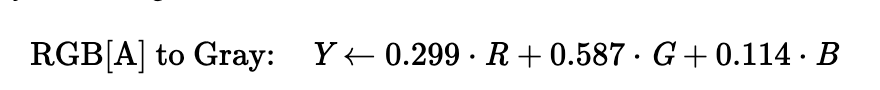

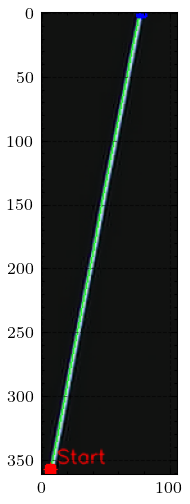

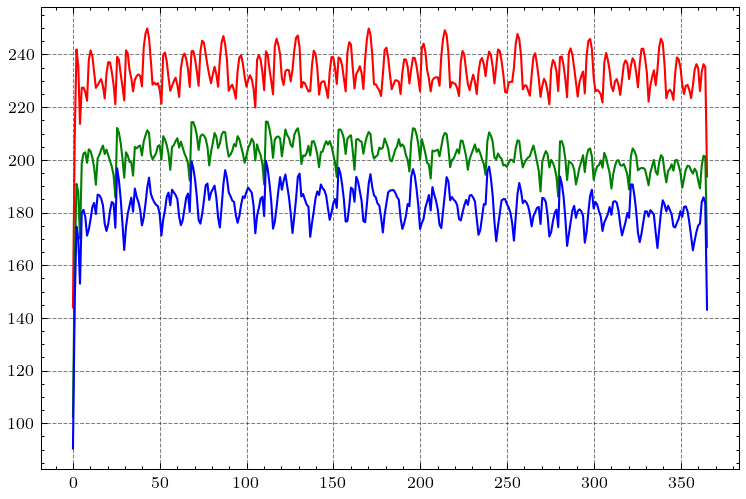

temp: 2300.56
	mean	std
r	234.06	6.54
g	205.43	4.46
b	184.71	6.27


In [34]:
T = lambda I: 108.0958765*I*I*I-511.9765339*I*I+1617.95649045*I+537.60415503
T = lambda I: 809*I + 956

analyzer = WireAnalyzer()

roi = cv2.imread("out/final_1662_roi.png")
mask = analyzer.brightness_mask(roi)
(dist, bri) = analyzer.analyze(roi, mask)

plt.plot(dist, bri['r'], color='red')
plt.plot(dist, bri['g'], color='green')
plt.plot(dist, bri['b'], color='blue')
plt.show()

idx = (dist >= 50) & (dist <= 150)
print(f'temp: {T(1.662):.2f}')
print('\tmean\tstd')
for col in ['r', 'g', 'b']:
    b = bri[col]
    print(f'{col}\t{np.mean(b[idx]):.2f}\t{np.std(b[idx]):.2f}')

In [21]:
0.299*197.23 + 0.587*130.99 + 0.114*110.93

148.50892